In [10]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
import geoplot as gplot
import geoplot as gplt
import matplotlib as mpl
import gc

In [11]:
def process_date(d):
    m,d,y = d.split('/')
    if len(m) < 2:
        m = '0' + m
    if len(d) < 2:
        d = '0' + d
    return '/'.join([m,d,y])

In [12]:
def rename_cols(df,ind):
    dct = dict(zip(list(df.columns[ind:-1]), [process_date(x) for x in list(df.columns[ind:-1])]))
    df.rename(columns=dct,inplace=True)

In [13]:
# load covid data
url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/'
conf = pd.read_csv(url + 'time_series_19-covid-Confirmed.csv')
dead = pd.read_csv(url + 'time_series_19-covid-Deaths.csv')
recs = pd.read_csv(url + 'time_series_19-covid-Recovered.csv')

In [14]:
conf.loc[conf['Province/State'].isna(), 'Province/State'] = 'none'
#conf['geometry'] = gpd.points_from_xy(conf['Long'], conf['Lat'])
rename_cols(conf,4)
conf.loc[conf['Province/State'] == 'France','Province/State'] = 'none'

dead.loc[dead['Province/State'].isna(), 'Province/State'] = 'none'
#dead['geometry'] = gpd.points_from_xy(dead['Long'], dead['Lat'])
rename_cols(dead,4)
dead.loc[dead['Province/State'] == 'France','Province/State'] = 'none'

recs.loc[recs['Province/State'].isna(), 'Province/State'] = 'none'
#recs['geometry'] = gpd.points_from_xy(recs['Long'], recs['Lat'])
rename_cols(recs,4)
recs.loc[recs['Province/State'] == 'France','Province/State'] = 'none'

In [15]:
# load geodata
url = 'https://raw.githubusercontent.com/deldersveld/topojson/master/'

# china
china = gpd.read_file(url + 'countries/china/china-provinces.json')
china.loc[china['NAME_1'] == 'Nei Mongol','NAME_1'] = 'Inner Mongolia'
china.loc[china['NAME_1'] == 'Xinjiang Uygur','NAME_1'] = 'Xinjiang'
china.loc[china['NAME_1'] == 'Xizang','NAME_1'] = 'Tibet'
china.loc[china['NAME_1'] == 'Ningxia Hui','NAME_1'] = 'Ningxia'
china.rename(columns={'NAME_1' : 'geounit'}, inplace=True)

# world
world = gpd.read_file(url + 'world-countries.json')
world = world.drop(world.loc[world['geometry'].is_empty].index)
world.rename(columns = {'name' : 'geounit'}, inplace=True)
world.loc[world['geounit'] == 'United States of America','geounit'] = 'US'

# europe
europe = gpd.read_file(url + 'continents/europe.json')
europe.drop(europe.loc[europe['geometry'].is_empty].index,inplace=True)
# remove Russie for now
europe.drop(europe.loc[europe['geounit']=='Russia'].index,inplace=True)
# make the UK
europe.loc[europe['geounit'] == 'England','geounit'] = 'United Kingdom'
europe.loc[europe['geounit'] == 'Scotland','geounit'] = 'United Kingdom'
europe.loc[europe['geounit'] == 'Wales','geounit'] = 'United Kingdom'
europe.loc[europe['geounit'] == 'Northern Ireland','geounit'] = 'United Kingdom'

# usa
usa = gpd.read_file(url + 'countries/united-states/us-albers.json')
usa = usa.drop(usa.loc[usa['geometry'].is_empty].index)
usa.rename(columns={'name' : 'geounit'},inplace=True)

# africa
africa = gpd.read_file(url + 'continents/africa.json')
africa.drop(africa.loc[africa['geometry'].is_empty].index,inplace=True)

# asia
asia = gpd.read_file(url + 'continents/asia.json')
asia.drop(asia.loc[asia['geometry'].is_empty].index,inplace=True)
# remove Russie for now
asia.drop(asia.loc[asia['geounit']=='Russia'].index,inplace=True)

# south america
samerica = gpd.read_file(url + 'continents/south-america.json')
samerica.drop(samerica.loc[samerica['geometry'].is_empty].index,inplace=True)

In [16]:
# some defs to use later
feature_spread='new_cases'
title_spread = 'cumulative cases'

feature_deaths='new_deaths'
title_deaths='cumulative deaths'

start_date=None

FIG_DIMS_H=(12,12)
FIG_DIMS_V=(8,12)
FIG_DPI=150

In [42]:
def log_scale(minval, maxval):
    def scalar(val):
        val = val + abs(minval) + 1
        return np.log10(val)
    return scalar

In [49]:
def identity_scale(minval, maxval):
    def scalar(val):
        return 2
    return scalar

In [56]:
def render_sub_frame(params=None): 
    # normalize colormap
    norm = mpl.colors.Normalize(vmin=params['color_min'], vmax=params['color_max'])
    cmap = mpl.cm.ScalarMappable(norm=norm, cmap=params['cmap']).cmap
    
    mode = params['mode']
    data = params['data']
    country = params['country']
    date = params['date']
    
    if country != None:
        data = data.loc[data['Country/Region'] == country]
    
    if mode == 'global':
        s_glob = data.loc[data['Province/State'] == 'none']
        s_locl = data.loc[data['Province/State'] != 'none']      
        
        sl = gpd.GeoDataFrame(s_locl,
                              geometry=gpd.points_from_xy(s_locl['Long'], s_locl['Lat']))
        sg = s_glob.loc[:,['Country/Region', date]].groupby('Country/Region').sum()
        
    elif mode == 'country':
        s_glob = data.loc[~data['Province/State'].str.contains(',')]
        s_locl = data.loc[data['Province/State'].str.contains(',')]
        
        sl = gpd.GeoDataFrame(s_locl,
                              geometry=gpd.points_from_xy(s_locl['Long'], s_locl['Lat']))
        sg = s_glob.loc[:,['Province/State', date]].groupby('Province/State').sum()
    else:
        pass
        
    #print(s_glob.head())
    #print(s_locl.head())
    #print(sg)
    
    # merge w/ map data
    geodata = params['map_data'].copy()
    geodata['raw'] = np.zeros(geodata.shape[0])
    geodata['log10'] = np.zeros(geodata.shape[0])
    
    for geounit in sg.index:
        geodata.loc[geodata['geounit'] == geounit,'log10'] = np.log10(sg.loc[geounit,date])
        geodata.loc[geodata['geounit'] == geounit,'raw'] = sg.loc[geounit,date]
    
    print(sl[date])
    gplot.choropleth(geodata,
                     hue='log10',
                     cmap=cmap,
                     ax=params['ax'],
                     norm=norm,
                     legend = True,
                    )
    
    gplot.pointplot(sl,
                    ax=params['ax'],
                    scale=date,
                    scale_func=identity_scale,
                    limits=(2,20)
                    )
    
    if params['annot']:
        for ix,row in geodata.iterrows():
            centroid = row['geometry'].centroid.coords
            x0 = centroid[0][0]
            y0 = centroid[0][1]
            params['ax'].text(x0, y0, int(row['raw']), fontsize=10)
    
    # derive date and time for plot title
    str_date = params['date']
    params['ax'].set_title('COVID19 '+ params['title_annot'] +' over time ' + params['date'])
    #del geodata

In [57]:
def plot_by_region(dims=(12,12),
                   dpi=150,
                   annot=True,
                   save_path=None,
                   mode='global',
                   country=None,
                   params=None,
                   verbose=True):
    ''' wrapper around render_subframe_by_country and render_subframe_by_state'''
    
    #dates = np.sort(data.columns[4:-1])
    n_plots = len(params)
    
    dates_l = [] 
    for fdict in params:
        dates_l.append(set(fdict['data'].columns[4:-1]))
        
    dates = list(set.intersection(*dates_l))
    dates.sort()
    
    #print(dates)
    for date in dates:        
        fig,axs = plt.subplots(n_plots, figsize=dims)
        
        ax_ind = 0
        for fdict in params:
            fdict['date'] = date
            fdict['annot'] = annot
            fdict['mode'] = mode
            fdict['country'] = country
                
            if n_plots == 1:
                fdict['ax'] = axs
            else:
                fdict['ax'] = axs[ax_ind]
                ax_ind += 1
            
            render_sub_frame(params=fdict)
            
        fig.tight_layout()
            
        if not os.path.exists(save_path):
            os.mkdir(save_path)
        if verbose:
            print('Created %s' %save_path)
            
        date_str = date.replace('/','')
        date_str = str(date_str[4:]) + str(date_str[0:2]) + str(date_str[2:4])
    
        fname = save_path + date_str + '.png'
        if verbose:
            print(fname)
            
        plt.savefig(fname, dpi=FIG_DPI)
        fig.clf()
        plt.close()
        
        # maybe running into RAM problems because creating too many figures
        gc.collect()

<ipython-input-56-cdcd1f36bdb4>:42: RuntimeWarning: divide by zero encountered in log10
  geodata.loc[geodata['geounit'] == geounit,'log10'] = np.log10(sg.loc[geounit,date])


209    0
210    0
211    0
212    0
213    0
      ..
395    0
396    0
397    0
398    0
399    0
Name: 01/22/20, Length: 191, dtype: int64
209    0
210    0
211    0
212    0
213    0
      ..
395    0
396    0
397    0
398    0
399    0
Name: 01/22/20, Length: 191, dtype: int64
209    0
210    0
211    0
212    0
213    0
      ..
395    0
396    0
397    0
398    0
399    0
Name: 01/23/20, Length: 191, dtype: int64
209    0
210    0
211    0
212    0
213    0
      ..
395    0
396    0
397    0
398    0
399    0
Name: 01/23/20, Length: 191, dtype: int64
209    0
210    0
211    0
212    0
213    0
      ..
395    0
396    0
397    0
398    0
399    0
Name: 01/24/20, Length: 191, dtype: int64
209    0
210    0
211    0
212    0
213    0
      ..
395    0
396    0
397    0
398    0
399    0
Name: 01/24/20, Length: 191, dtype: int64
209    0
210    0
211    0
212    0
213    0
      ..
395    0
396    0
397    0
398    0
399    0
Name: 01/25/20, Length: 191, dtype: int64
209    0
210 

KeyboardInterrupt: 

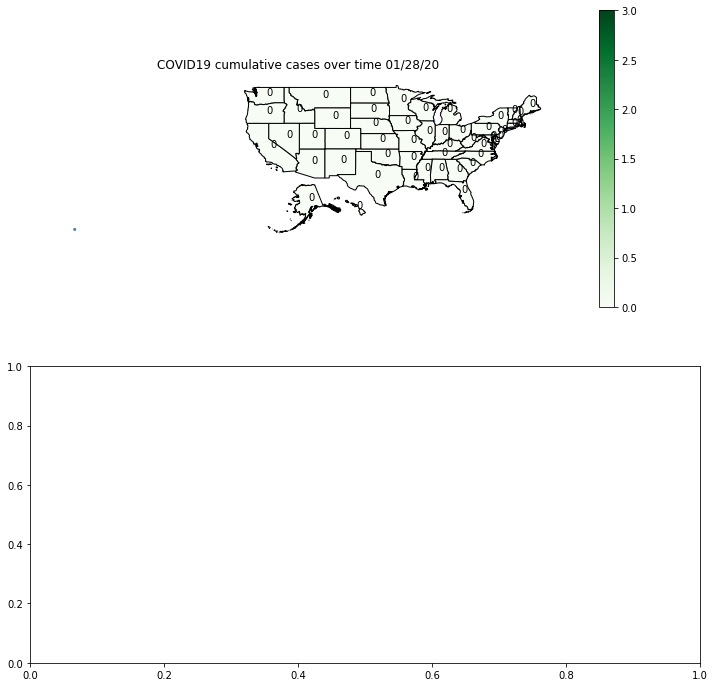

In [58]:
# USA
color_max_usa_spread=3   # 1000
color_max_usa_deaths=1   # 10

usa_spread = {
    'data' : conf,
    'color_min' : 0,
    'color_max' : color_max_usa_spread,
    'cmap' : 'Greens',
    'map_data' : usa,
    'feature': feature_spread,
    'title_annot' : title_spread
}

usa_death = {
    'data' : dead,
    'color_min' : 0,
    'color_max' : color_max_usa_deaths,
    'cmap' : 'Reds',
    'map_data' : usa,
    'feature': feature_deaths,
    'title_annot' : title_deaths
}

plot_by_region(dims=FIG_DIMS_H,
               annot=True,
               verbose=False,
               params=[usa_spread, usa_death],
               mode='country',
               save_path='./usa/',
               country='US',
               dpi=FIG_DPI)

In [69]:
def print_full(x):
    pd.set_option('display.max_rows', x.shape[0])
    pd.set_option('display.max_columns', x.shape[1])
    print(x)
    pd.reset_option('display.max_rows')
    pd.reset_option('display.max_columns')

In [71]:
conf.loc[(conf['Country/Region'] == 'US') & (conf['Province/State'].str.contains(','))].head(n=50)

,Province/State,Country/Region,Lat,Long,01/22/20,01/23/20,01/24/20,01/25/20,01/26/20,01/27/20,...,03/10/20,03/11/20,03/12/20,03/13/20,03/14/20,03/15/20,03/16/20,03/17/20,03/18/20,3/19/20
209,"Kitsap, WA",US,47.6477,-122.6413,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
210,"Solano, CA",US,38.3105,-121.9018,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
211,"Santa Cruz, CA",US,37.0454,-121.9580,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
212,"Napa, CA",US,38.5025,-122.2654,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
213,"Ventura, CA",US,34.3705,-119.1391,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
214,"Worcester, MA",US,42.4097,-71.8571,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
215,"Gwinnett, GA",US,33.9191,-84.0167,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
216,"DeKalb, GA",US,33.7956,-84.2279,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
217,"Floyd, GA",US,37.5455,-82.7779,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
218,"Fayette, GA",US,33.4502,-84.4803,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
